In [1]:
from graph2net.trainers import generate
from graph2net.archetypes import inception,resNet,resNeXt
from graph2net.graph_generators import show_cell, gen_cell
from graph2net.data_loaders import load_data, visualize_loader
import graph2net.notifier
from graph2net.notifier import notify_me
from graph2net.petri import create_gene_pool,run_petri, mutate_pool

from IPython.core.display import display, HTML
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import logging

pd.options.mode.chained_assignment = None 
logging.basicConfig(filename='logs/model_testbed.log', level=logging.INFO)

display(HTML("<style>.container { width:100% !important; }</style>"))

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
def list_flatten(l):
    return [item for sublist in l for item in sublist]

data = load_data(batch_size=256)
ground_truths = np.array(list_flatten([tgt.tolist() for img,tgt in data[1]]))

In [53]:
def get_ensembling(adult_df):
    valids = adult_df[adult_df['correct']>0]
    top_n_mean=(valids['preds'].cumsum())/(np.arange(len(valids))+1)
    top_n_preds = [np.argmax(x,1) for x in top_n_mean]
    top_n_corrects = [np.sum(x==ground_truths) for x in top_n_preds]
    top_n_corrects += [0]*(len(adult_df)-len(valids))
    adult_df['top_n_corrects']=top_n_corrects
    return adult_df

In [120]:
inclusions = [{"cell":inception,"genotype":'inception'},
              {"cell":resNeXt,"genotype":'resNeXt'},
              {"cell":resNet,"genotype":'resNet'}]

creation_params = {'node_range':[5,13],
                  'connectivity_range':[.25,.75],
                  'concat':.5}

In [121]:
pool = create_gene_pool(2,inclusions=inclusions,creation_params=creation_params)

In [122]:
pool

,acc_preds,adult,cell,confidence,correct,genotype,lineage,loss,macro_pred,mutations,name,offspring,params,preds,type
0,0,False,"[[0.0, 1.0, 12.0, 0.0, 1.0, 0.0, 0.0, 10.0, 0....",0,0,"n: 12, c: 0.263",[],0.0,0,0,Ozark Levin Caldwell,0,0,[],sum
1,0,False,"[[0.0, 1.0, 13.0, 0.0, 9.0, 0.0, 1.0, 0.0], [1...",0,0,"n: 8, c: 0.437",[],0.0,0,0,Kim Houdaille Dostoevsky,0,0,[],concat
2,0,False,"[[0, 11, 11, 5, 11], [1, 0, 0, 0, 13], [1, 0, ...",0,0,inception,[],0.0,0,0,Hottentot Carthage Christopher,0,0,[],concat
3,0,False,"[[0, 3, 0, 1], [0, 0, 13, 0], [0, 0, 0, 2], [0...",0,0,resNeXt,[],0.0,0,0,Louisiana Minos Shakespeare,0,0,[],sum
4,0,False,"[[0, 12, 1, 0, 0], [0, 0, 12, 0, 0], [0, 0, 0,...",0,0,resNet,[],0.0,0,0,Lykes Conner Andrea,0,0,[],sum


In [ ]:
for generation in range(5):
    print("=== GENERATION {} ===".format(generation))
    adult_df = run_petri(pool,data=data,connectivity='linear',cell_types=[1,1],scale=2,epochs=3,verbose=False,predict=True)
    adult_df = get_ensembling(adult_df)
    display(adult_df)
    adult_df.to_pickle("generations/generation_{}.pkl".format(generation))
    #pool = mutate_pool(adult_df, parents=25, children=50, mutation_probability=.25, new_entries=50, creation_params=creation_params)
    pool = mutate_pool(adult_df, parents=2, children=3, mutation_probability=.25, new_entries=2, creation_params=creation_params)

=== GENERATION 0 ===


,acc_preds,adult,cell,confidence,correct,genotype,lineage,loss,macro_pred,mutations,name,offspring,params,preds,type,top_n_corrects
1,4708,True,"[[0.0, 1.0, 13.0, 0.0, 9.0, 0.0, 1.0, 0.0], [1...",367,4046,"n: 8, c: 0.437",[],2.0998,7766,0,Kim Houdaille Dostoevsky,0,6391,"[[-1.4255796670913696, -2.563965320587158, 0.8...",concat,4046
3,4696,True,"[[0, 3, 0, 1], [0, 0, 13, 0], [0, 0, 0, 2], [0...",367,4186,resNeXt,[],1.7525,7720,0,Louisiana Minos Shakespeare,0,6044,"[[-0.7777613997459412, -0.2571380138397217, -0...",sum,4494
2,4668,True,"[[0, 11, 11, 5, 11], [1, 0, 0, 0, 13], [1, 0, ...",367,4099,inception,[],2.0061,7708,0,Hottentot Carthage Christopher,0,6034,"[[-1.6754698753356934, -2.0090110301971436, 0....",concat,4606
4,4522,True,"[[0, 12, 1, 0, 0], [0, 0, 12, 0, 0], [0, 0, 0,...",367,3963,resNet,[],2.0490,7612,0,Lykes Conner Andrea,0,6230,"[[-0.19779188930988312, -0.09784789383411407, ...",sum,4672
0,3888,True,"[[0.0, 1.0, 12.0, 0.0, 1.0, 0.0, 0.0, 10.0, 0....",367,3048,"n: 12, c: 0.263",[],1.4981,7275,0,Ozark Levin Caldwell,0,8518,"[[-0.9554283618927002, 0.23868374526500702, 2....",sum,4665


Mutating cell  3  of  3 ...
=== GENERATION 1 ===of  2 ...


<ErrorbarContainer object of 3 artists>

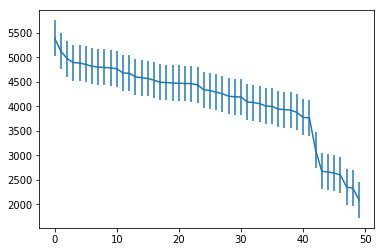

In [76]:
plt.errorbar(x=range(len(adult_df)),y=adult_df['acc_preds'],yerr=adult_df['confidence'])